In [4]:
import os
import h5py
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
from scipy.optimize import root
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
data_dir = "hubbard_dmrg_3"
exact_file = "hubbard_exact.hdf5"
l = 3
output_filename = f"hubbard_{l}_error_ut_6_new.pdf"
d_max = 30
d_min = 3

if l == 2:
    num_cnot = 22
elif l == 3:
    num_cnot = 191
elif l == 4:
    num_cnot = 472
else:
    raise ValueError(f"Invalid dimension {l}")

In [6]:
all_files = os.listdir(data_dir)
assert exact_file in all_files
ev_files = [f for f in all_files if "eigenvalues" in f]
print(len(ev_files))

11


In [7]:
# Get the exact energy.
f_exact = h5py.File(data_dir + "/" + exact_file, "r")
energy_exact = f_exact["energy"][()]
print(f"Exact energy is {energy_exact}.")
f_exact.close()

Exact energy is -2.3661456273199915.


In [8]:
# subspace_files = [f for f in all_files if "subspace" in f]
# for i in range(len(subspace_files)):
#     f_subspace = h5py.File(data_dir + "/" + subspace_files[i])
#     ref_energy = f_subspace["reference_energy"][()]
#     f_subspace.close()
#     print(f"Reference energy = {ref_energy}")

In [9]:
dfs = []
for evf in ev_files:
    fname = data_dir + "/" + evf
    # Get the number of steps.
    f = h5py.File(fname, "r")
    steps = f["steps"][()]
    f.close()
    # Get the upper bound.
    # fname2 = fname.replace("eigenvalues", "bound")
    # bound_df = pd.read_hdf(fname2)
    # Get the dataframe with energy vs. d
    df = pd.read_hdf(fname, key="eigenvalues")
    df["error"] = abs(df["energy"] - energy_exact)
    df["steps"] = steps
    df["num_2q"] = steps * num_cnot
    df.set_index("d")
    # df_concat = pd.concat([df, bound_df], axis=1)
    # dfs.append(df_concat)
    dfs.append(df)
df_total = pd.concat(dfs)
print(df_total)

     d       eps       energy  num_pos        error  steps  num_2q
i                                                                 
0    3  0.000001    -2.322930        3     0.043215     50    9550
1    4  0.000001    -2.345987        4     0.020158     50    9550
2    5  0.000001    -2.352506        5     0.013640     50    9550
3    6  0.000001    -2.355186        5     0.010960     50    9550
4    7  0.000001    -2.358326        5     0.007820     50    9550
..  ..       ...          ...      ...          ...    ...     ...
23  26  0.000001 -2519.223395       13  2516.857249     10    1910
24  27  0.000001 -2950.060064       13  2947.693918     10    1910
25  28  0.000001 -3495.716341       13  3493.350195     10    1910
26  29  0.000001 -5868.788881       14  5866.422736     10    1910
27  30  0.000001 -6705.159003       14  6702.792858     10    1910

[308 rows x 7 columns]


In [10]:
df_small = df_total[df_total["d"] >= 20]
print(df_small)

     d       eps       energy  num_pos        error  steps  num_2q
i                                                                 
17  20  0.000001 -2210.098333        9  2207.732187     50    9550
18  21  0.000001 -2387.049551       10  2384.683405     50    9550
19  22  0.000001 -2877.047553       10  2874.681408     50    9550
20  23  0.000001 -4034.266733       10  4031.900587     50    9550
21  24  0.000001 -4296.377604       10  4294.011458     50    9550
..  ..       ...          ...      ...          ...    ...     ...
23  26  0.000001 -2519.223395       13  2516.857249     10    1910
24  27  0.000001 -2950.060064       13  2947.693918     10    1910
25  28  0.000001 -3495.716341       13  3493.350195     10    1910
26  29  0.000001 -5868.788881       14  5866.422736     10    1910
27  30  0.000001 -6705.159003       14  6702.792858     10    1910

[121 rows x 7 columns]


In [11]:
df_inter = df_total[df_total["d"] <= d_max]
df_small = df_inter[df_inter["d"] >= d_min]
print(df_small.head())

   d       eps    energy  num_pos     error  steps  num_2q
i                                                         
0  3  0.000001 -2.322930        3  0.043215     50    9550
1  4  0.000001 -2.345987        4  0.020158     50    9550
2  5  0.000001 -2.352506        5  0.013640     50    9550
3  6  0.000001 -2.355186        5  0.010960     50    9550
4  7  0.000001 -2.358326        5  0.007820     50    9550


In [12]:
chemical_accuracy = 0.00159 * l ** 2
print(f"Chemical accuracy is {chemical_accuracy} ha.")

Chemical accuracy is 0.01431 ha.


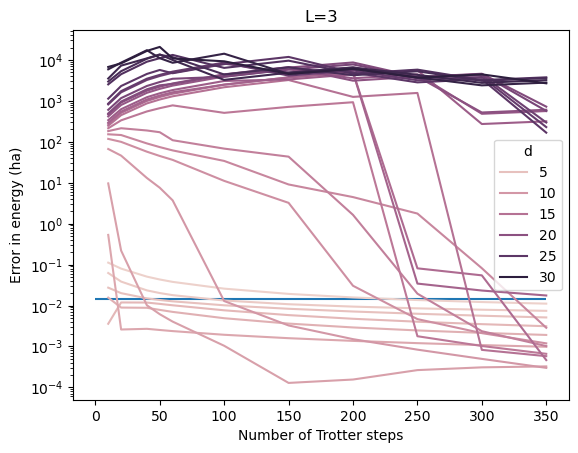

In [13]:
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.hlines(chemical_accuracy, 0, 350)
sns.lineplot(ax=ax, data=df_small, x="steps", y="error", hue="d")
# plt.ylim(top=chemical_accuracy+ 0.01)
ax.set_xlabel("Number of Trotter steps")
ax.set_ylabel("Error in energy (ha)")
plt.title(f"L={l}")
plt.savefig(output_filename)

In [14]:
def find_num_steps(steps, errors, accuracy, t0):
    """Find the number of steps for a given accuracy by interpolation."""

    assert np.min(errors) <= accuracy <= np.max(errors),\
        f"Accuracy {accuracy} must be between {np.min(errors)} and {np.max(errors)}"
    spline = CubicSpline(steps, errors)
    solution = root(lambda nt: spline(nt) - accuracy, t0)
    if not solution.success:
        print("Solver did not converge.")
    return solution.x

In [15]:
for d in range(3, 17):
    df_d = df_total[df_total["d"] == d]
    errors = df_d["error"].to_numpy()
    print(d, np.min(errors), np.max(errors))

3 0.011107657639465973 0.11142518727594997
4 0.007412627215896528 0.0622692672575722
5 0.005113649207128201 0.027306611430409244
6 0.0031207388061247343 0.011875693052316283
7 0.0019107462251461982 0.0155928438585895
8 0.0009807836827993022 0.5306363926426791
9 0.00012869276177562838 9.603283777425272
10 0.00030024116942906076 66.52700834728833
11 0.0011902398072494158 117.34613020762662
12 0.002862171514848466 152.09450350344432
13 0.0010215277437182202 213.61057451963114
14 0.000661096558514096 922.3904712975435
15 0.0005796257002539384 3214.650471121229
16 0.0004648096523838241 4968.8307005817915


In [16]:
# For each given error, find how many steps it would take to produce, along wih the required d.
errs = [0.1, 0.1, 1e-2, 1e-2, 1e-2, 1e-3, 5e-4]
ds = [3, 4, 7, 8, 9, 14, 15]
nt0 = [50, 50, 250, 200, 200, 200, 200] # Guess at number of steps.

for err, d, nt in zip(errs, ds, nt0):
    df_d = df_total[df_total["d"] == d]
    df_d.sort_values("steps", inplace=True)
    errors = df_d["error"].to_numpy()
    steps = df_d["steps"].to_numpy()
    steps = find_num_steps(steps, errors, err, nt)
    print(err, d, steps)

0.1 3 [13.04371819]


/var/folders/rv/3v7hvpgn6ks14zr4w90jz4zc0000gn/T/ipykernel_9015/1125365208.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_d.sort_values("steps", inplace=True)


AssertionError: Accuracy 0.1 must be between 0.007412627215896528 and 0.0622692672575722